In [ ]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import lightgbm
import category_encoders
import missingno
import boruta
import tsfresh
import sktime
import statsmodels
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import shap
import re
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    fbeta_score,
    cohen_kappa_score,
    make_scorer
)
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer



In [2]:
features_wide = pd.read_csv("C:/Users/u840716/Anna Thesis/Code Files -/Models/ML_models/summary_features_wide_final_2.csv")

### Exploration of missingness

In [3]:
num_features = features_wide.drop(columns=["PatID", "Patient_Type"]).shape[1]
print(f"Number of features (excluding PatID and Patient_Type): {num_features}")

Number of features (excluding PatID and Patient_Type): 762


In [4]:
nan_count = features_wide.isna().sum().sum()
print(f"Total number of NaN values in features_wide: {nan_count}")

Total number of NaN values in features_wide: 217737


In [5]:
total_data_points = features_wide.size
nan_percentage = (nan_count / total_data_points) * 100

print(f"Total data points in features_wide: {total_data_points}")
print(f"Number of NaN values: {nan_count}")
print(f"Percentage of NaN values: {nan_percentage:.2f}%")

Total data points in features_wide: 1626556
Number of NaN values: 217737
Percentage of NaN values: 13.39%


In [ ]:

nan_mask = features_wide.isna()

nan_mask['Patient_Type'] = features_wide['Patient_Type']

# Count total NaNs per group (VT = 1, Control = 0)
nan_by_group = nan_mask.groupby('Patient_Type').sum().sum(axis=1)

# Count total data points per group
group_counts = features_wide['Patient_Type'].value_counts()
total_data_points_by_group = group_counts * (features_wide.shape[1] - 1)  # -1 to exclude Patient_Type column

# Percentage NaNs by group
nan_percentage_by_group = (nan_by_group / total_data_points_by_group) * 100

print("NaN counts by Patient_Type:")
print(nan_by_group)
print("\nTotal data points by group:")
print(total_data_points_by_group)
print("\nPercentage of NaNs by group:")
print(nan_percentage_by_group.round(2))


NaN counts by Patient_Type:
Patient_Type
0    202012
1     15725
dtype: int64

Total data points by group:
Patient_Type
0    1515318
1     109109
Name: count, dtype: int64

Percentage of NaNs by group:
Patient_Type
0    13.33
1    14.41
dtype: float64


In [ ]:
# Drop Patient_Type column for missingness analysis
features_only = features_wide.drop(columns=['Patient_Type'])

# column with the most missing values
nan_per_column = features_only.isna().sum()
worst_column = nan_per_column.idxmax()
worst_column_nan_count = nan_per_column.max()

print(f"Feature with most missing values: {worst_column}")
print(f"Total missing values in that feature: {worst_column_nan_count}")

missing_mask = features_wide[worst_column].isna()
present_mask = ~missing_mask

# missing values by Patient_Type (1 = VT, 0 = Control)
missing_by_type = features_wide.loc[missing_mask, 'Patient_Type'].value_counts()
n_vt_missing = missing_by_type.get(1, 0)
n_control_missing = missing_by_type.get(0, 0)

# total values (non-missing + missing) by Patient_Type
total_by_type = features_wide.loc[:, ['Patient_Type', worst_column]].groupby('Patient_Type').size()
n_vt_total = total_by_type.get(1, 0)
n_control_total = total_by_type.get(0, 0)

# percentage of missing values within each class
pct_vt_missing = (n_vt_missing / n_vt_total) * 100 if n_vt_total > 0 else 0
pct_control_missing = (n_control_missing / n_control_total) * 100 if n_control_total > 0 else 0

print(f"Missing values from VT patients (1): {n_vt_missing} / {n_vt_total} ({pct_vt_missing:.2f}%)")
print(f"Missing values from Control patients (0): {n_control_missing} / {n_control_total} ({pct_control_missing:.2f}%)")


Feature with most missing values: mean_after_cutoff_Troponine-T_CZE00281
Total missing values in that feature: 1283
Missing values from VT patients (1): 58 / 143 (40.56%)
Missing values from Control patients (0): 1225 / 1986 (61.68%)


### Evaluation function

In [8]:
def evaluate_model(model, X_test, y_test, model_name="Model", save_fig=False):
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Basic Metrics
    cm = confusion_matrix(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    kappa = cohen_kappa_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"Evaluation for {model_name}")
    print("-" * 40)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F2 Score: {f2:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("-" * 40)

    # Plotting
    plt.figure(figsize=(18, 5))

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"])
    plt.yticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"], rotation=0)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    if save_fig:
        plt.savefig(f"{model_name.replace(' ', '_')}_evaluation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

### Baseline - No adjustments (also no imputation)

XGBoost can still work with NaN values in the dataset, so we first try the baseline version

In [9]:
# 1. Prepare features and labels
X = features_wide.drop(columns=["PatID", "Patient_Type"])  # Features
original_columns = X.columns if isinstance(X, pd.DataFrame) else [f"feature_{i}" for i in range(X.shape[1])]
y = features_wide["Patient_Type"]  # Labels

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Initialize XGBoost classifier
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    missing=np.nan,
    random_state=42
)

# 4. Fit model
model.fit(X_train, y_train)

# 5. Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation for XGBoost Classifier
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       397
           1       0.29      0.07      0.11        29

    accuracy                           0.92       426
   macro avg       0.61      0.53      0.54       426
weighted avg       0.89      0.92      0.90       426

F2 Score: 0.0813
Cohen’s Kappa: 0.0869
ROC AUC Score: 0.7837
----------------------------------------


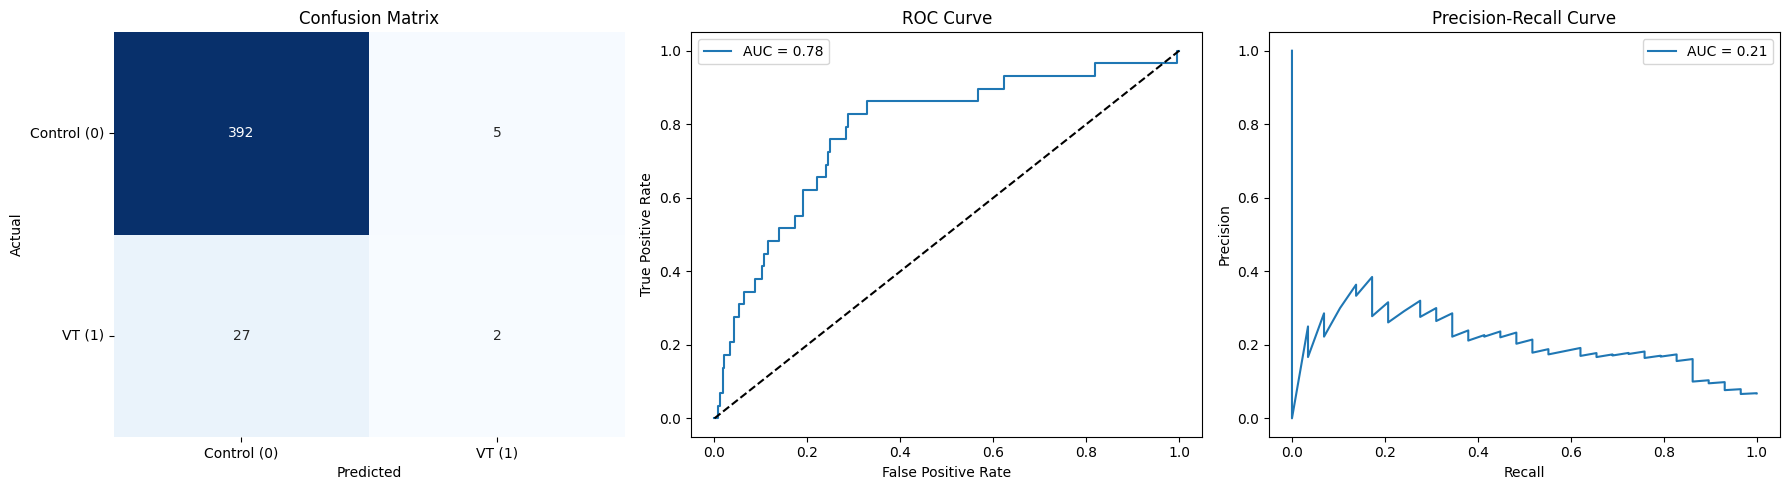

In [ ]:
# 6. Evaluation
evaluate_model(model, X_test, y_test, model_name="XGBoost Classifier")


In [ ]:
# mask missing values
FILL_VALUE = -999
X_train_masked = X_train.fillna(FILL_VALUE)

# Oversample the training set
smote   = SMOTE(random_state=42)
adasyn  = ADASYN(random_state=42)

X_sm, y_sm = smote.fit_resample(X_train_masked, y_train)
X_ad, y_ad = adasyn.fit_resample(X_train_masked, y_train)

# Fit & evaluate XGBoost on each
for name, (X_tr, y_tr) in {
    "SMOTE":   (X_sm, y_sm),
    "ADASYN":  (X_ad, y_ad)
}.items():
    clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        missing=np.nan,
        random_state=42
    )
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(f"\n XGBoost + {name} ")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:25:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost + SMOTE 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       596
           1       0.50      0.14      0.22        43

    accuracy                           0.93       639
   macro avg       0.72      0.56      0.59       639
weighted avg       0.91      0.93      0.91       639

ROC AUC: 0.78012330263774
Confusion Matrix:
 [[590   6]
 [ 37   6]]


c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost + ADASYN 
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       596
           1       0.67      0.19      0.29        43

    accuracy                           0.94       639
   macro avg       0.81      0.59      0.63       639
weighted avg       0.93      0.94      0.92       639

ROC AUC: 0.767675979397534
Confusion Matrix:
 [[592   4]
 [ 35   8]]


Imputation Exploration

In [13]:
# Count missing values per column in the full dataset
missing_per_feature = X.isna().sum()

# Sort in descending order and get top 10
top_10_missing_features = missing_per_feature.sort_values(ascending=False).head(10)

# Calculate missing percentage
missing_percentages = (top_10_missing_features / len(X)) * 100

# Create summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': top_10_missing_features,
    'Missing %': missing_percentages.round(2)
})

print("Top 10 Features with Highest Missingness in the Full Dataset:")
print(missing_summary)


Top 10 Features with Highest Missingness in the Full Dataset:
                                                    Missing Count  Missing %
mean_after_cutoff_Troponine-T_CZE00281                       1283      60.26
duration_after_cutoff_days_Troponine-T_CZE00281              1283      60.26
value_after_cutoff_Troponine-T_CZE00281                      1283      60.26
Age_at_Start                                                 1275      59.89
value_before_cutoff_eGFR (CKD-EPI)_CS002396                  1231      57.82
duration_before_cutoff_days_eGFR (CKD-EPI)_CS00...           1231      57.82
mean_before_cutoff_eGFR (CKD-EPI)_CS002396                   1231      57.82
mean_after_cutoff_CK-MB_CZE00267                             1186      55.71
duration_after_cutoff_days_CK-MB_CZE00267                    1186      55.71
value_after_cutoff_CK-MB_CZE00267                            1186      55.71


In [ ]:
# Identify top 10 missingness features in full data
top_10_features = X.isna().sum().sort_values(ascending=False).head(10).index.tolist()

# Create masks for VT and Control groups
vt_mask = y == 1
control_mask = y == 0

X_vt = X[vt_mask]
X_control = X[control_mask]

# Count missing values for each group
vt_missing = X_vt[top_10_features].isna().sum()
control_missing = X_control[top_10_features].isna().sum()

# Percentages
vt_missing_pct = (vt_missing / len(X_vt)) * 100
control_missing_pct = (control_missing / len(X_control)) * 100

group_missing_summary = pd.DataFrame({
    'VT Missing Count': vt_missing,
    'VT Missing %': vt_missing_pct.round(2),
    'Control Missing Count': control_missing,
    'Control Missing %': control_missing_pct.round(2)
})

print("Missingness in VT and Control Groups for Top 10 Features:")
print(group_missing_summary)


Missingness in VT and Control Groups for Top 10 Features:
                                                    VT Missing Count  \
mean_after_cutoff_Troponine-T_CZE00281                            58   
duration_after_cutoff_days_Troponine-T_CZE00281                   58   
value_after_cutoff_Troponine-T_CZE00281                           58   
Age_at_Start                                                      68   
value_before_cutoff_eGFR (CKD-EPI)_CS002396                       84   
duration_before_cutoff_days_eGFR (CKD-EPI)_CS00...                84   
mean_before_cutoff_eGFR (CKD-EPI)_CS002396                        84   
mean_after_cutoff_CK-MB_CZE00267                                  57   
duration_after_cutoff_days_CK-MB_CZE00267                         57   
value_after_cutoff_CK-MB_CZE00267                                 57   

                                                    VT Missing %  \
mean_after_cutoff_Troponine-T_CZE00281                     40.56   
duration_afte

In [16]:
# Count total missing values
total_missing = X_test.isna().sum().sum()

# Total data points in test set
total_points = X_test.size

# Calculate percentage
missing_percentage = (total_missing / total_points) * 100

# Output
print(f"Total data points in test set: {total_points}")
print(f"Total missing values in test set: {total_missing}")
print(f"Percentage of missing values in test set: {missing_percentage:.2f}%")


Total data points in test set: 324612
Total missing values in test set: 40006
Percentage of missing values in test set: 12.32%


# Imputation

In [27]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# 1. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 2. Split by class
X_vt_train = X_train[y_train == 1]
X_control_train = X_train[y_train == 0]
X_vt_test = X_test[y_test == 1]
X_control_test = X_test[y_test == 0]




In [33]:
def impute_and_evaluate(imputer_vt, imputer_control, name):
    X_vt_train_imputed = pd.DataFrame(imputer_vt.fit_transform(X_vt_train), columns=X.columns)
    X_control_train_imputed = pd.DataFrame(imputer_control.fit_transform(X_control_train), columns=X.columns)

    X_vt_test_imputed = pd.DataFrame(imputer_vt.transform(X_vt_test), columns=X.columns)
    X_control_test_imputed = pd.DataFrame(imputer_control.transform(X_control_test), columns=X.columns)

    X_train_final = pd.concat([X_vt_train_imputed, X_control_train_imputed])
    y_train_final = pd.concat([y_train[y_train == 1], y_train[y_train == 0]])

    X_test_final = pd.concat([X_vt_test_imputed, X_control_test_imputed])
    y_test_final = pd.concat([y_test[y_test == 1], y_test[y_test == 0]])

    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    model.fit(X_train_final, y_train_final)

    evaluate_model(model, X_test_final, y_test_final, model_name=f"XGBoost - {name}")


c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation for XGBoost - Mean Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       397
           1       1.00      0.79      0.88        29

    accuracy                           0.99       426
   macro avg       0.99      0.90      0.94       426
weighted avg       0.99      0.99      0.99       426

F2 Score: 0.8273
Cohen’s Kappa: 0.8772
ROC AUC Score: 0.9903
----------------------------------------


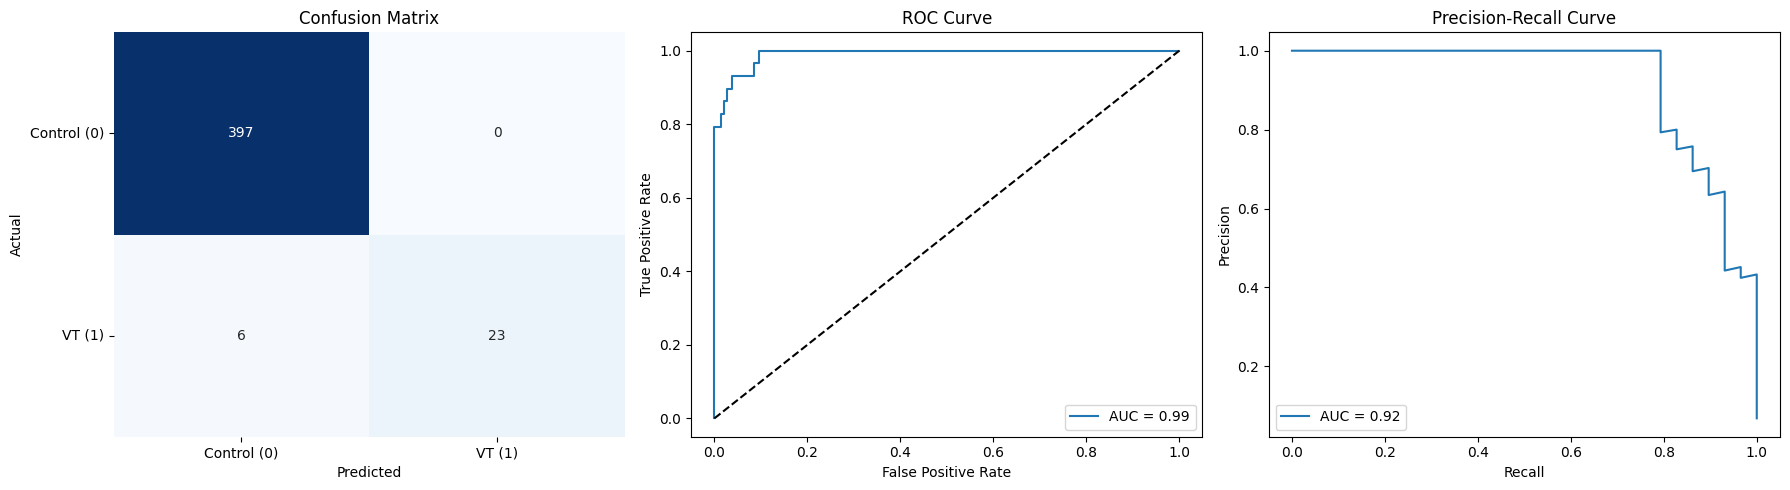

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation for XGBoost - Median Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       397
           1       0.91      0.72      0.81        29

    accuracy                           0.98       426
   macro avg       0.95      0.86      0.90       426
weighted avg       0.98      0.98      0.98       426

F2 Score: 0.7554
Cohen’s Kappa: 0.7954
ROC AUC Score: 0.9917
----------------------------------------


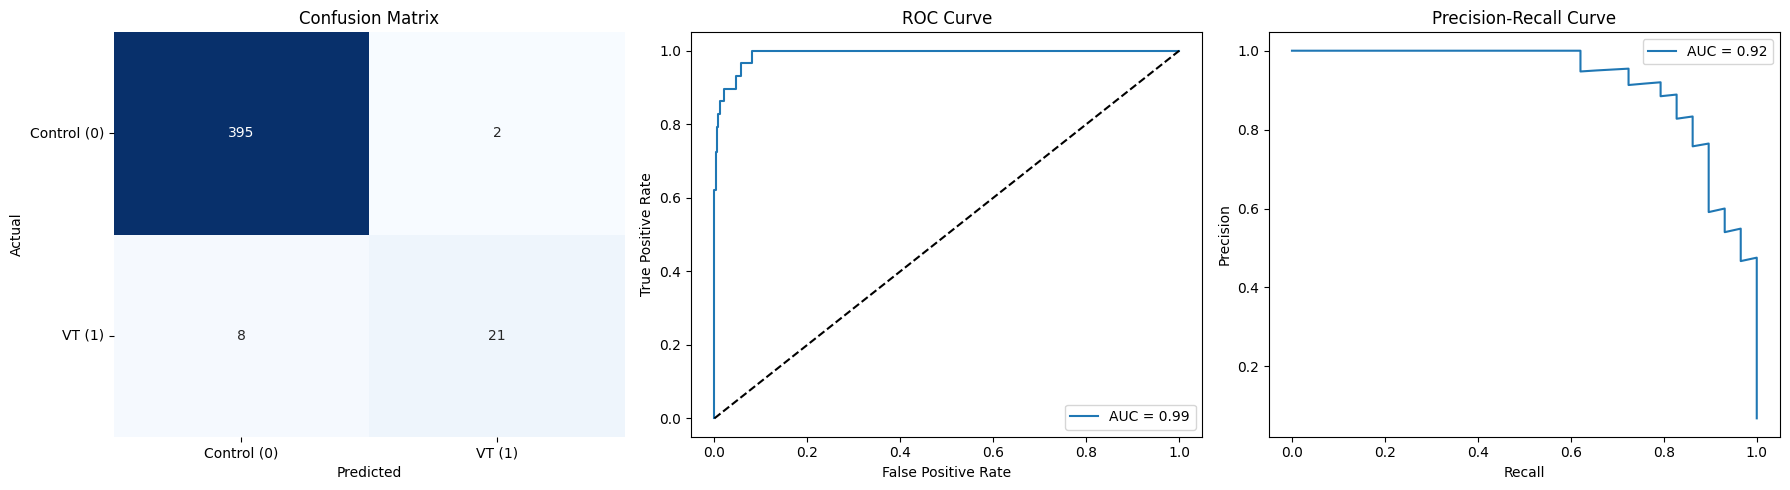

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation for XGBoost - KNN Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       397
           1       0.70      0.24      0.36        29

    accuracy                           0.94       426
   macro avg       0.82      0.62      0.66       426
weighted avg       0.93      0.94      0.93       426

F2 Score: 0.2778
Cohen’s Kappa: 0.3358
ROC AUC Score: 0.9201
----------------------------------------


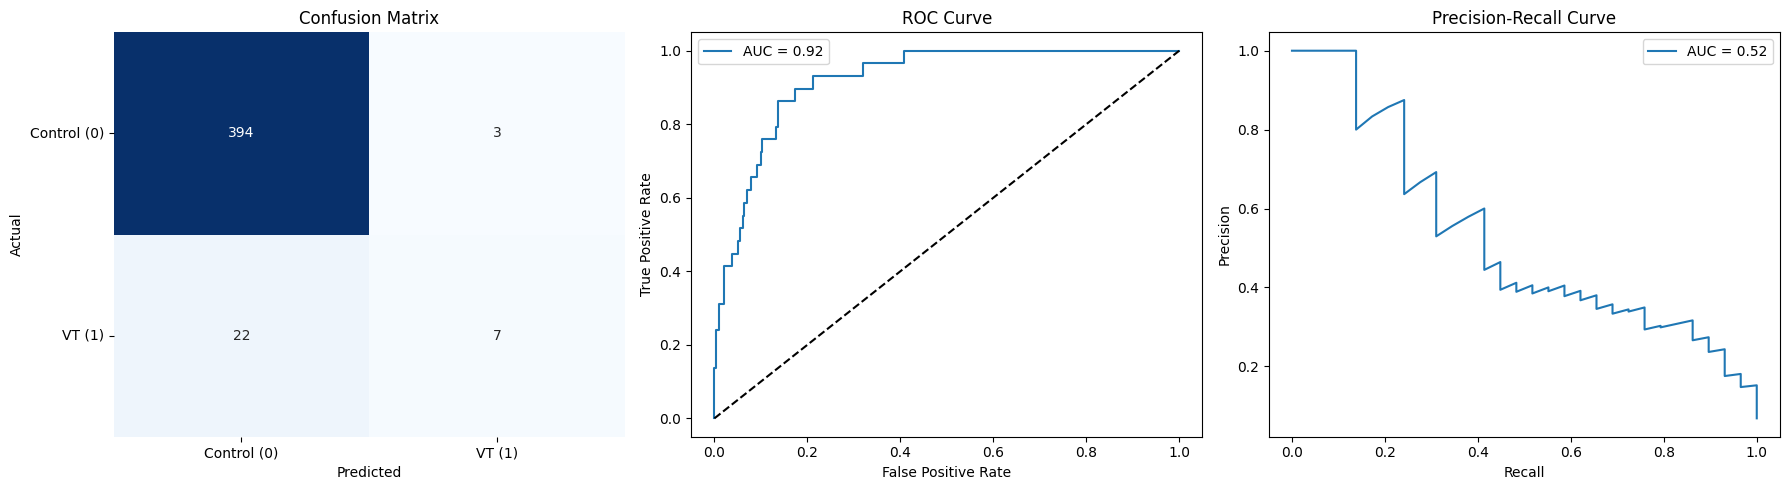

In [39]:
mean_vt = SimpleImputer(strategy='mean')
mean_control = SimpleImputer(strategy='mean')
impute_and_evaluate(mean_vt, mean_control, "Mean Imputation (per class)")

median_vt = SimpleImputer(strategy='median')
median_control = SimpleImputer(strategy='median')
impute_and_evaluate(median_vt, median_control, "Median Imputation (per class)")

knn_vt = KNNImputer(n_neighbors=5)
knn_control = KNNImputer(n_neighbors=5)
impute_and_evaluate(knn_vt, knn_control, "KNN Imputation (per class)")



Mean performs best

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation for XGBoost - Mean Imputation + ADASYN
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       397
           1       0.89      0.86      0.88        29

    accuracy                           0.98       426
   macro avg       0.94      0.93      0.93       426
weighted avg       0.98      0.98      0.98       426

F2 Score: 0.8681
Cohen’s Kappa: 0.8684
ROC AUC Score: 0.9896
----------------------------------------


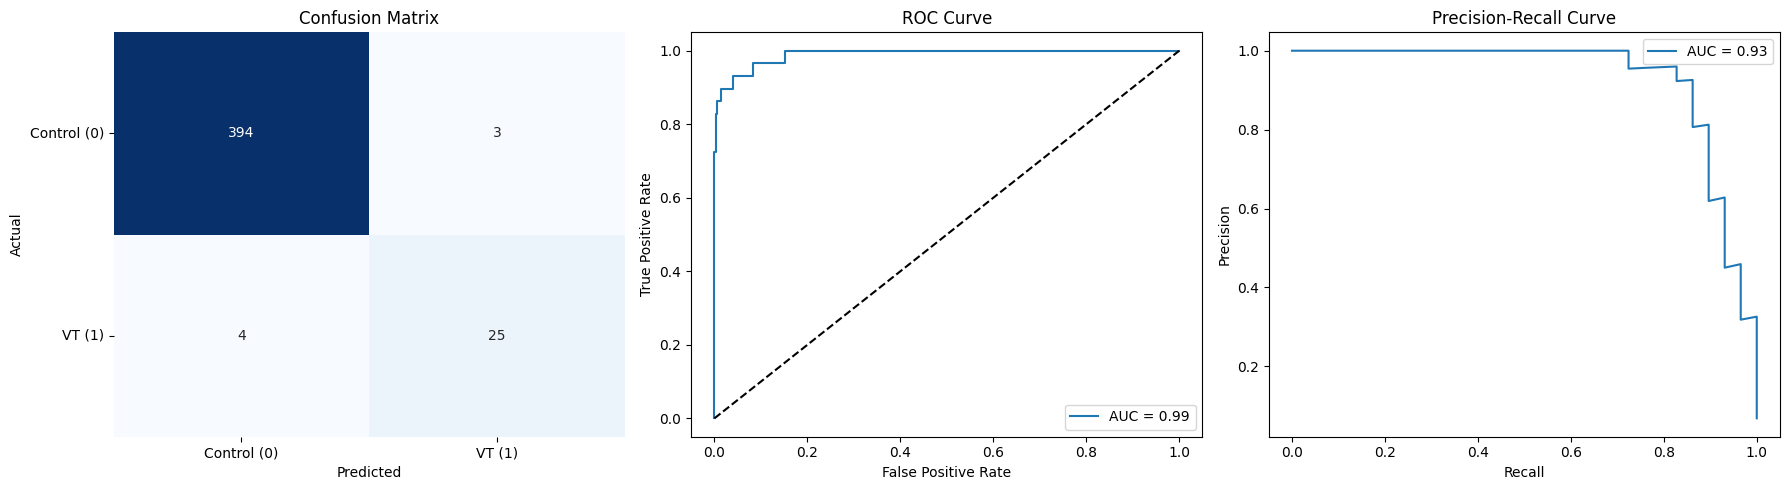

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation for XGBoost - Mean Imputation + SMOTE
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       397
           1       0.93      0.86      0.89        29

    accuracy                           0.99       426
   macro avg       0.96      0.93      0.94       426
weighted avg       0.99      0.99      0.99       426

F2 Score: 0.8741
Cohen’s Kappa: 0.8853
ROC AUC Score: 0.9918
----------------------------------------


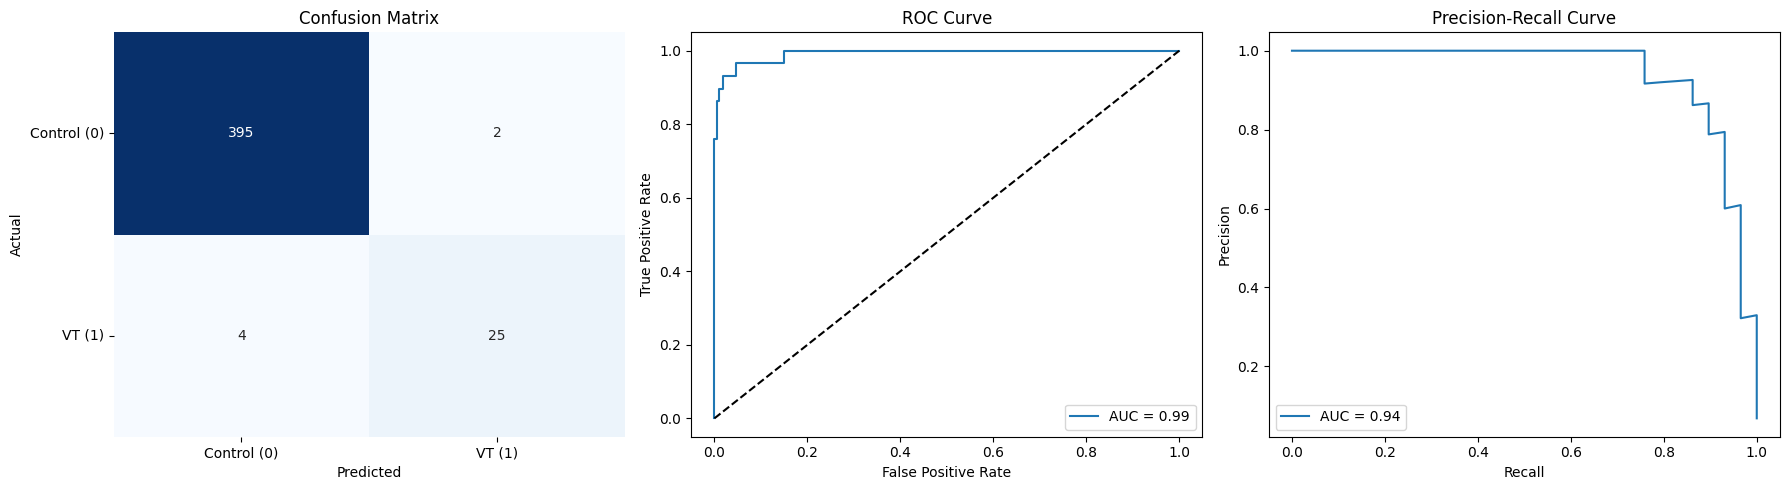

In [57]:
# Mean Imputers for VT and Control
mean_vt = SimpleImputer(strategy='mean')
mean_control = SimpleImputer(strategy='mean')

# Impute Train Set
X_vt_train_imputed = pd.DataFrame(mean_vt.fit_transform(X_vt_train), columns=X.columns)
X_control_train_imputed = pd.DataFrame(mean_control.fit_transform(X_control_train), columns=X.columns)
X_train_mean = pd.concat([X_vt_train_imputed, X_control_train_imputed])
y_train_mean = pd.concat([y_train[y_train == 1], y_train[y_train == 0]])

# Impute Test Set using train imputers
X_vt_test_imputed = pd.DataFrame(mean_vt.transform(X_vt_test), columns=X.columns)
X_control_test_imputed = pd.DataFrame(mean_control.transform(X_control_test), columns=X.columns)
X_test_mean = pd.concat([X_vt_test_imputed, X_control_test_imputed])
y_test_mean = pd.concat([y_test[y_test == 1], y_test[y_test == 0]])

# Shuffle training data
X_train_mean, y_train_mean = shuffle(X_train_mean, y_train_mean, random_state=42)

# Define oversamplers
adasyn = ADASYN(random_state=42)
smote = SMOTE(random_state=42)

# Apply ADASYN
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_mean, y_train_mean)
model_adasyn = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
model_adasyn.fit(X_train_adasyn, y_train_adasyn)
evaluate_model(model_adasyn, X_test_mean, y_test_mean, model_name="XGBoost - Mean Imputation + ADASYN", save_fig=True)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_mean, y_train_mean)
model_smote = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
evaluate_model(model_smote, X_test_mean, y_test_mean, model_name="XGBoost - Mean Imputation + SMOTE", save_fig=True)

mean and smote is the best combination for XGB

Best Performing Model:
XGBoost + Mean Imputation + SMOTE is slightly better across the most relevant metrics for this case

# Hyperparameter Tuning

first attempt, slightly improved

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters Found:
{'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Evaluation for Tuned XGBoost + Mean Imputation + SMOTE
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       397
           1       0.93      0.86      0.89        29

    accuracy                           0.99       426
   macro avg       0.96      0.93      0.94       426
weighted avg       0.99      0.99      0.99       426

F2 Score: 0.8741
Cohen’s Kappa: 0.8853
ROC AUC Score: 0.9919
----------------------------------------


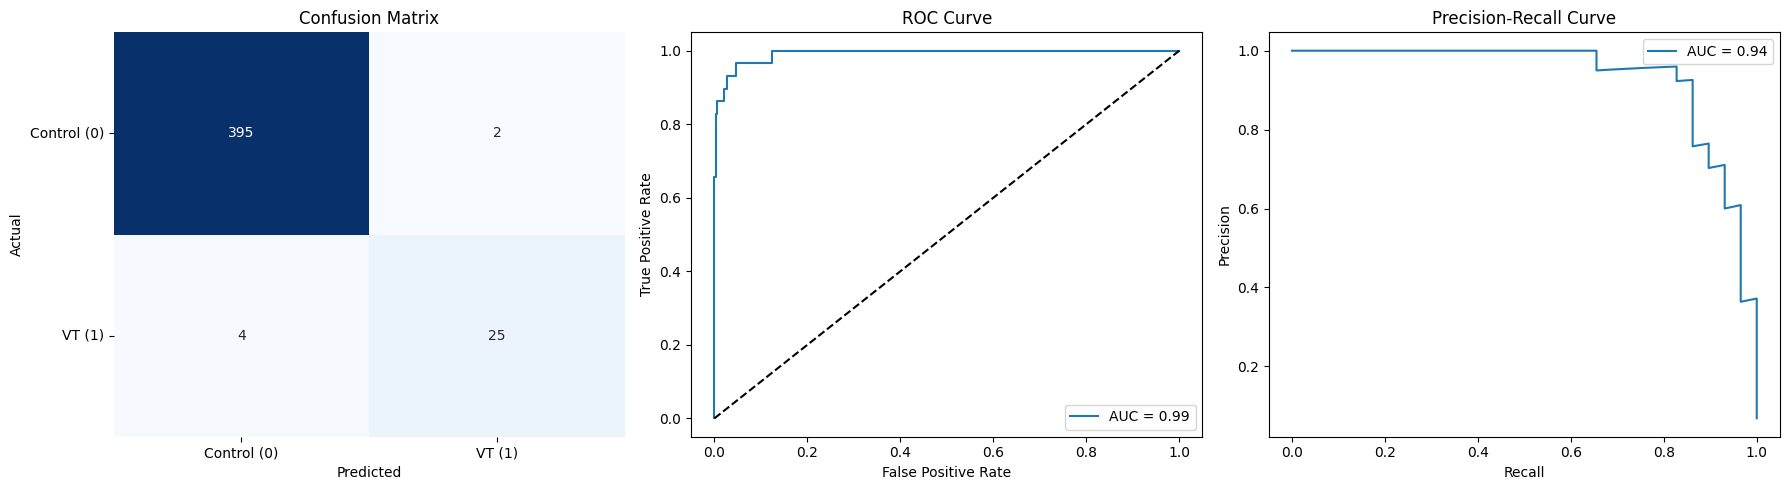

In [ ]:
# Define parameter grid for tuning
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.5, 1],
    "reg_lambda": [1, 1.5, 2],
    "reg_alpha": [0, 0.5, 1]
}

# Define model and scorer
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# F2 score is more suitable for recall-prioritized settings like medical applications
scorer = make_scorer(fbeta_score, beta=2)

# Perform randomized search
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,  # or fewer if needed
    scoring=scorer,
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

search.fit(X_train_smote, y_train_smote)

# Get the best model
best_model_1 = search.best_estimator_

print("Best Parameters Found:")
print(search.best_params_)

# Evaluate on test set
evaluate_model(best_model_1, X_test_mean, y_test_mean, model_name="Tuned XGBoost + Mean Imputation + SMOTE")


second attempt, same

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:12:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters Found: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Evaluation for Tuned XGBoost + Mean Imputation + ADASYN (CV)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       397
           1       0.93      0.86      0.89        29

    accuracy                           0.99       426
   macro avg       0.96      0.93      0.94       426
weighted avg       0.99      0.99      0.99       426

F2 Score: 0.8741
Cohen’s Kappa: 0.8853
ROC AUC Score: 0.9950
----------------------------------------


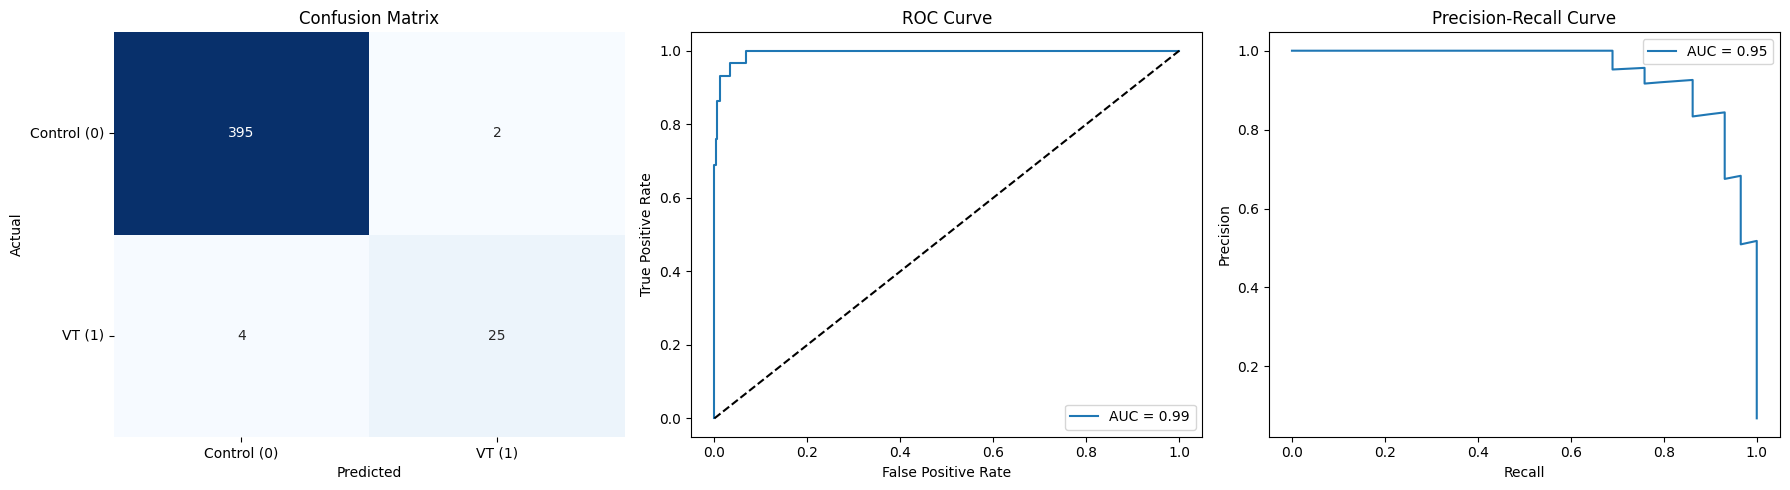

In [44]:
# Define Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use the same param_dist as before

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,  # or increase if time allows
    scoring=scorer,
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

search.fit(X_train_smote, y_train_smote)

best_model = search.best_estimator_
print("Best Parameters Found:", search.best_params_)

evaluate_model(best_model, X_test_mean, y_test_mean, model_name="Tuned XGBoost + Mean Imputation + ADASYN (CV)")


Evaluation for Tuned XGBoost + Mean Imputation + ADASYN (CV)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       397
           1       0.93      0.86      0.89        29

    accuracy                           0.99       426
   macro avg       0.96      0.93      0.94       426
weighted avg       0.99      0.99      0.99       426

F2 Score: 0.8741
Cohen’s Kappa: 0.8853
ROC AUC Score: 0.9950
----------------------------------------


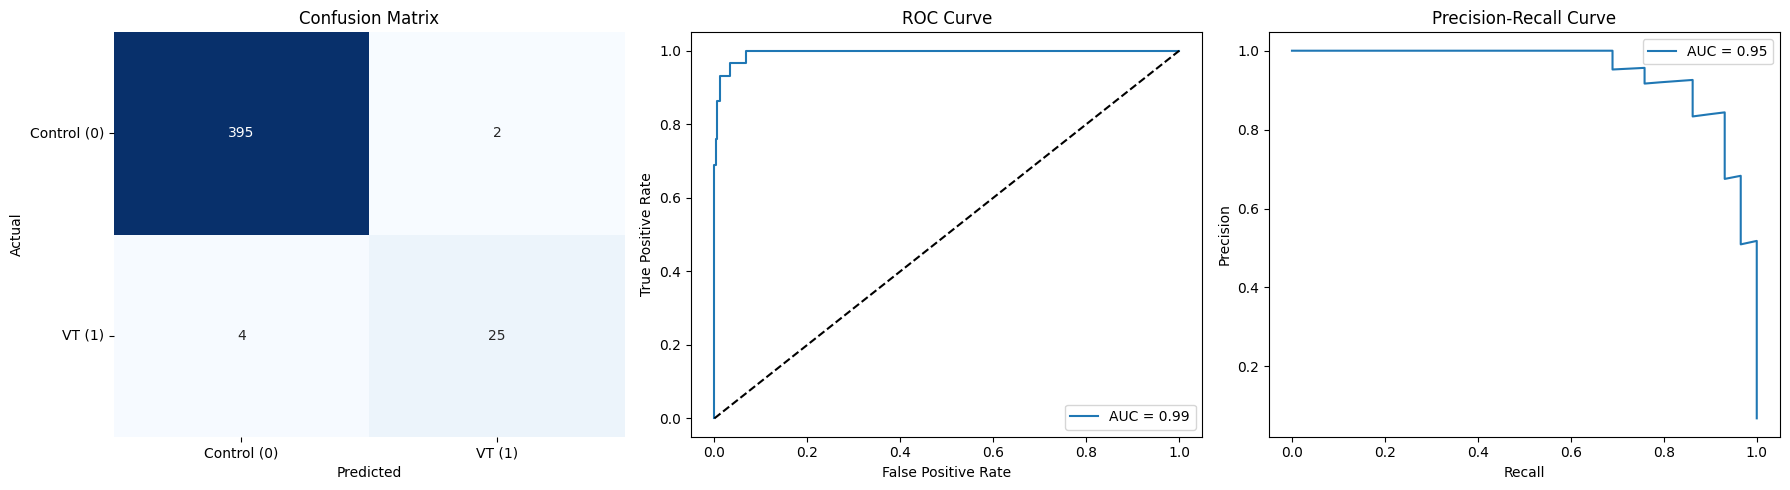

In [45]:
evaluate_model(best_model, X_test_mean, y_test_mean, model_name="Tuned XGBoost + Mean Imputation + ADASYN (CV)", save_fig=True)

# Feature Importance

## SHAP

### Global vs Local

In [ ]:

sample_X = X_test_mean

# Create SHAP explainer (TreeExplainer)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(sample_X)



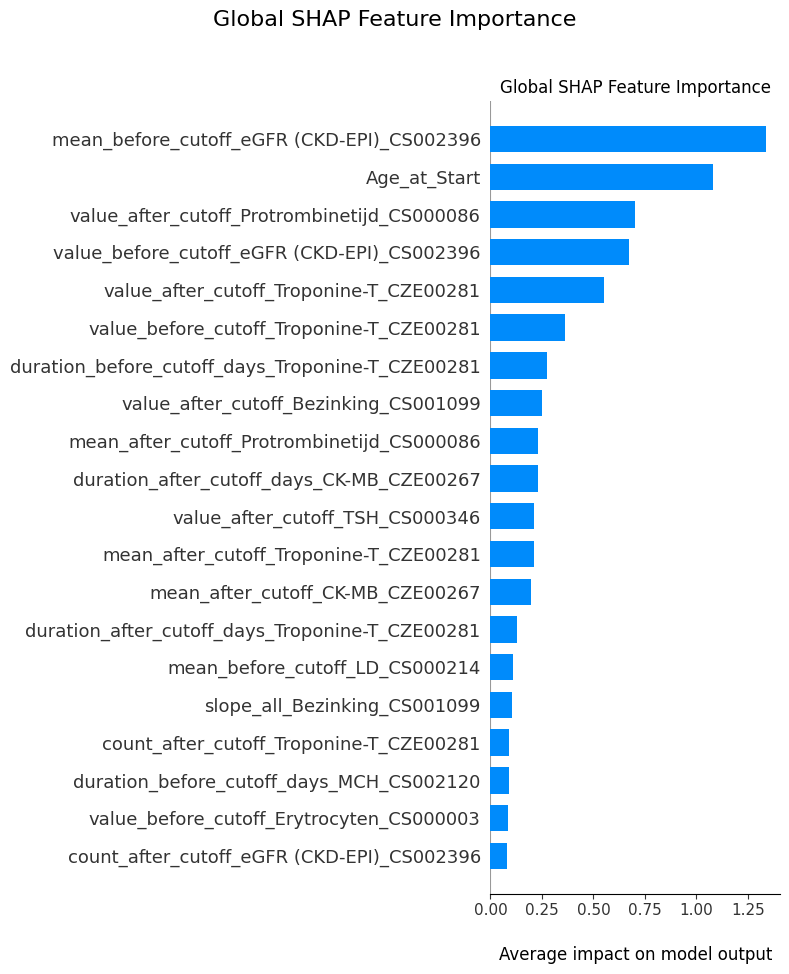

In [ ]:
plt.figure(figsize=(18, 18))
shap.summary_plot(shap_values, sample_X, plot_type="bar", show=False)
plt.title("Global SHAP Feature Importance")

plt.gca().set_xlabel("Average impact on model output", fontsize=12, labelpad=20)
plt.suptitle("Global SHAP Feature Importance", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("SHAP/shap_summary_bar.pdf", format='pdf', bbox_inches='tight')
plt.show()


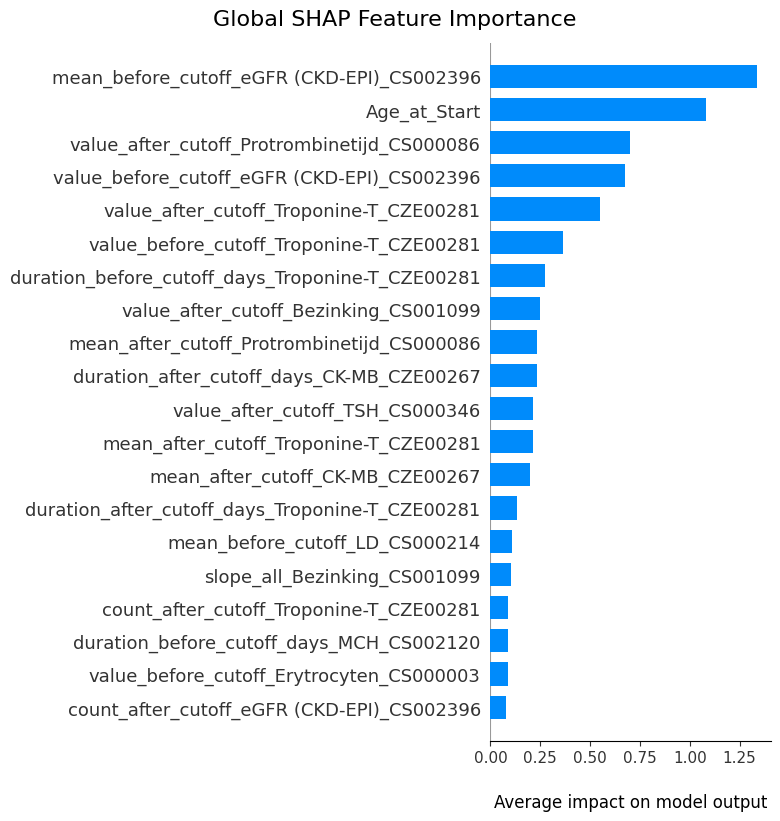

In [ ]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, sample_X, plot_type="bar", show=False)


plt.subplots_adjust(bottom=0.25)
plt.gca().set_xlabel("Average impact on model output", fontsize=12, labelpad=20)

plt.suptitle("Global SHAP Feature Importance", fontsize=16, y=1.02)
plt.savefig("SHAP/shap_summary_bar.pdf", format='pdf', bbox_inches='tight')
plt.show()

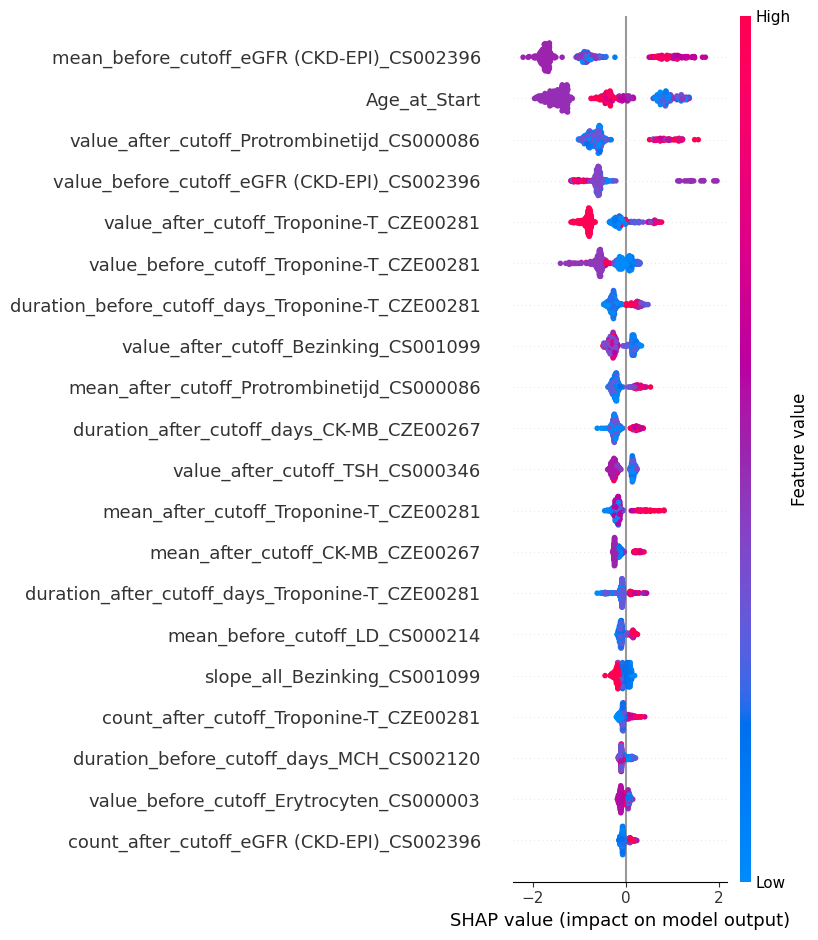

<Figure size 640x480 with 0 Axes>

In [51]:
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, sample_X)
plt.tight_layout()
plt.savefig("SHAP/shap_summary_beeswarm.pdf", format='pdf', bbox_inches='tight')
plt.show()

# plot shows both impact and direction (red: higher value, blue: lower value)

(positive SHAP means more likely VT, negative SHAP is more like control)

### Local bar plots

In [52]:

# Get model predictions
y_pred_probs = best_model.predict_proba(X_test_mean)[:, 1]
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Identify true labels 
# Ensure y_test_mean is a 1D array
y_test_labels = y_test_mean.ravel()

# Identify example indices for local plots 
tp_index = np.where((y_pred_labels == 1) & (y_test_labels == 1))[0][0]  # True Positive
fp_index = np.where((y_pred_labels == 1) & (y_test_labels == 0))[0][0]  # False Positive
tn_index = np.where((y_pred_labels == 0) & (y_test_labels == 0))[0][0]  # True Negative
fn_index = np.where((y_pred_labels == 0) & (y_test_labels == 1))[0][0]  # False Negative




C:\Users\u840716\AppData\Local\Temp\2\ipykernel_5572\1924442111.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test_labels = y_test_mean.ravel()


Local SHAP Explanation: True Positive


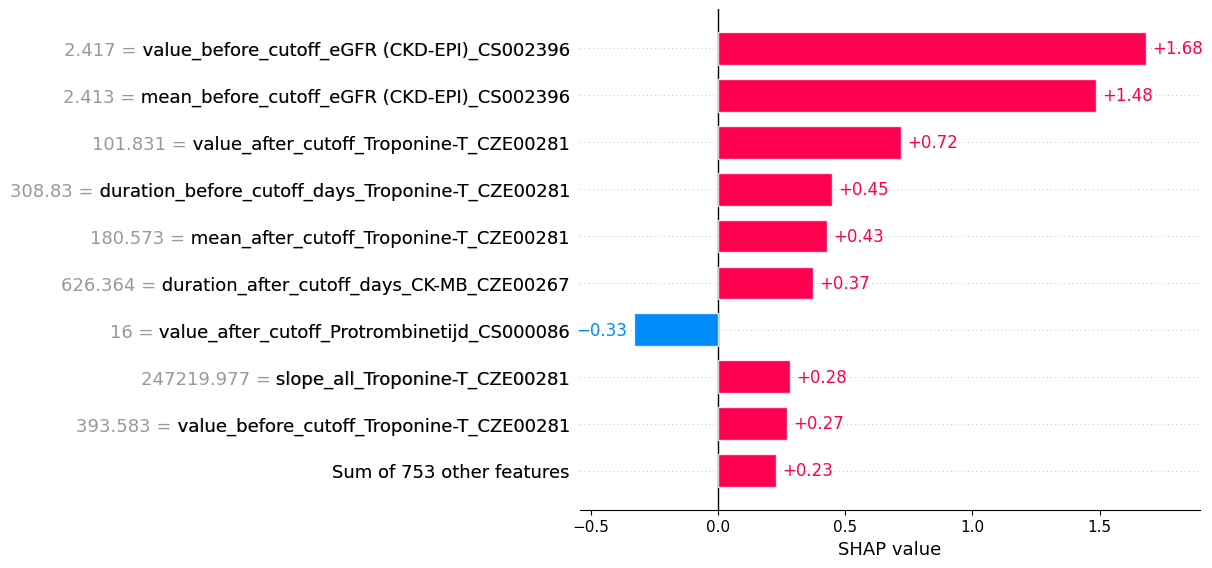

Local SHAP Explanation: False Positive


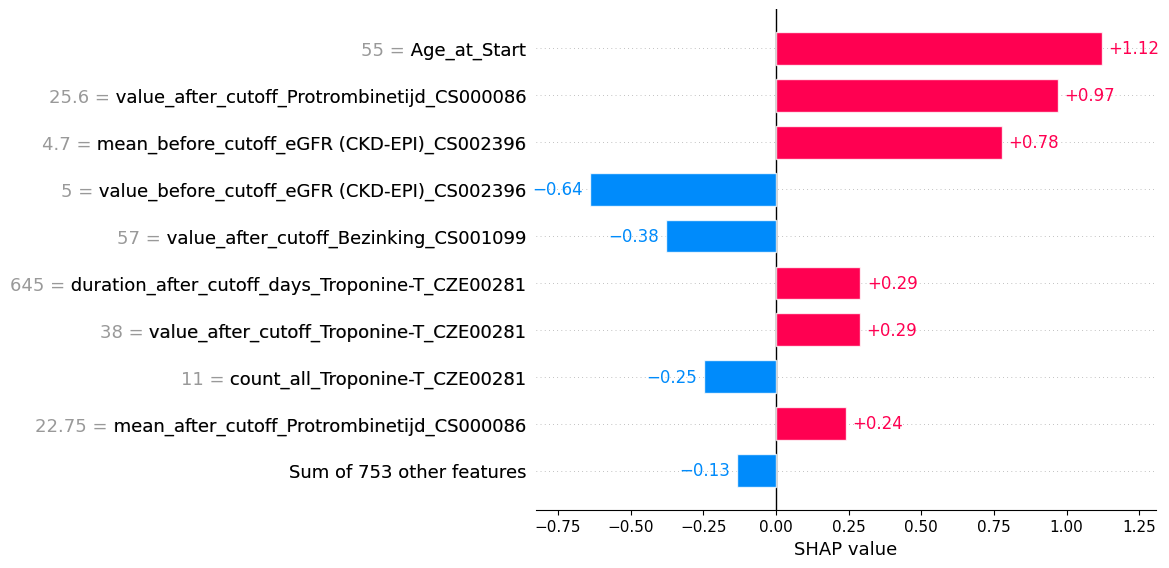

Local SHAP Explanation: True Negative


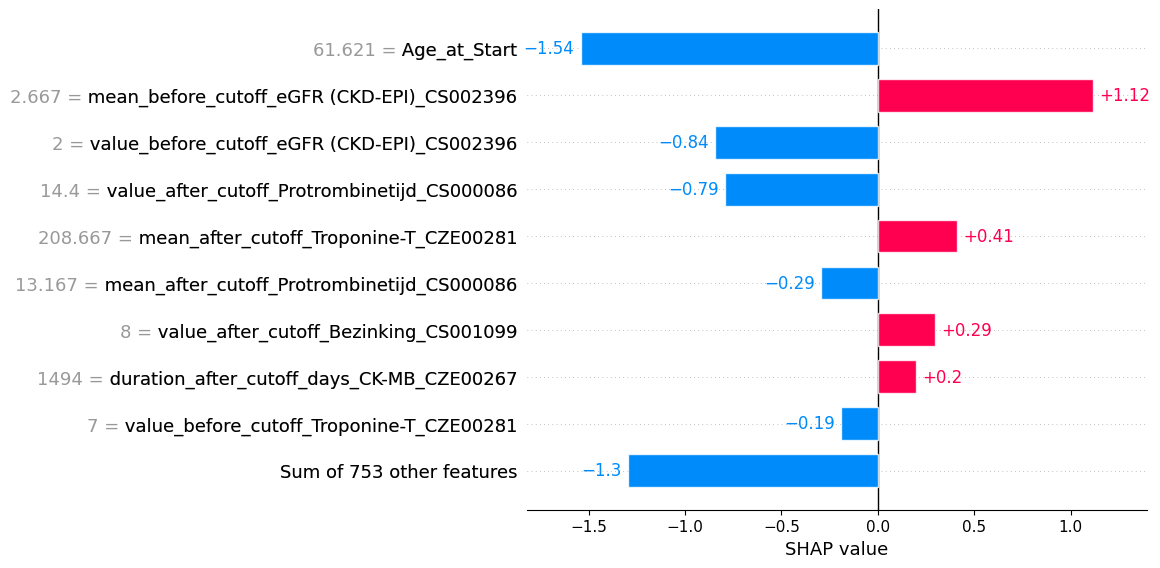

Local SHAP Explanation: False Negative


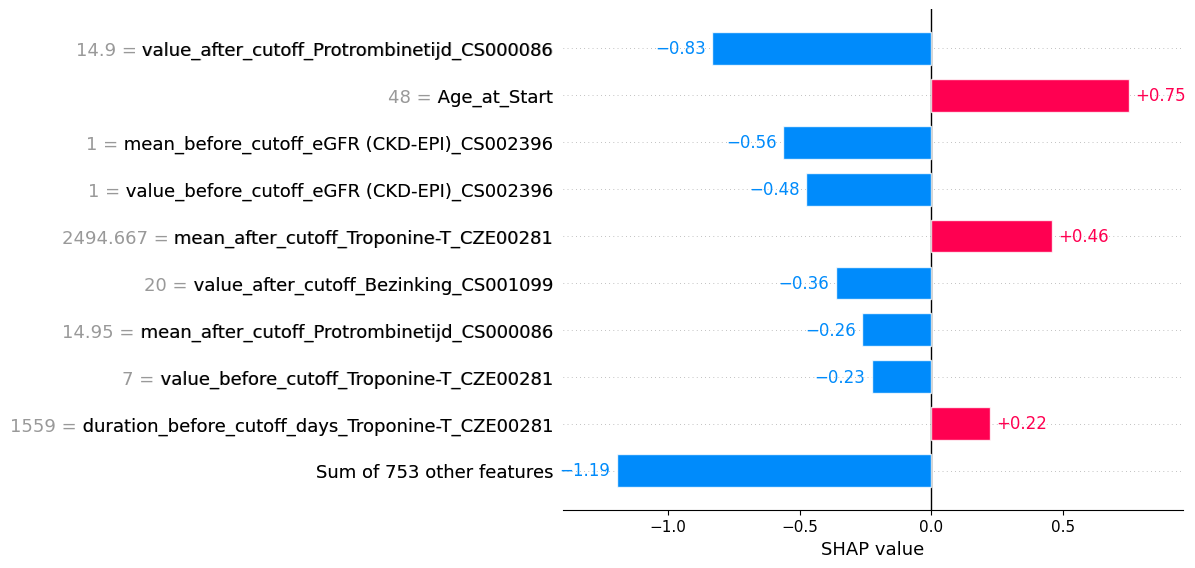

In [54]:
# True Positive
tp_expl = shap.Explanation(
    values=shap_values[tp_index],
    base_values=explainer.expected_value,
    data=sample_X.iloc[tp_index],
    feature_names=sample_X.columns.tolist()
)
print("Local SHAP Explanation: True Positive")
shap.plots.bar(tp_expl, max_display=10)  # No plt.show() or plt.title()

# False Positive
fp_expl = shap.Explanation(
    values=shap_values[fp_index],
    base_values=explainer.expected_value,
    data=sample_X.iloc[fp_index],
    feature_names=sample_X.columns.tolist()
)
print("Local SHAP Explanation: False Positive")
shap.plots.bar(fp_expl, max_display=10)

# True Negative
tn_expl = shap.Explanation(
    values=shap_values[tn_index],
    base_values=explainer.expected_value,
    data=sample_X.iloc[tn_index],
    feature_names=sample_X.columns.tolist()
)
print("Local SHAP Explanation: True Negative")
shap.plots.bar(tn_expl, max_display=10)

# False Negative
fn_expl = shap.Explanation(
    values=shap_values[fn_index],
    base_values=explainer.expected_value,
    data=sample_X.iloc[fn_index],
    feature_names=sample_X.columns.tolist()
)
print("Local SHAP Explanation: False Negative")
shap.plots.bar(fn_expl, max_display=10)


In [55]:
# Function to save SHAP bar plots
def save_shap_bar_plot(expl, label):
    plt.figure()
    shap.plots.bar(expl, max_display=10, show=False)
    plt.tight_layout()
    plt.savefig(f"SHAP/shap_local_bar_{label}.pdf", format='pdf', bbox_inches='tight')
    plt.close()

# True Positive
tp_expl = shap.Explanation(
    values=shap_values[tp_index],
    base_values=explainer.expected_value,
    data=sample_X.iloc[tp_index],
    feature_names=sample_X.columns.tolist()
)
print("Local SHAP Explanation: True Positive")
save_shap_bar_plot(tp_expl, "true_positive")

# False Positive
fp_expl = shap.Explanation(
    values=shap_values[fp_index],
    base_values=explainer.expected_value,
    data=sample_X.iloc[fp_index],
    feature_names=sample_X.columns.tolist()
)
print("Local SHAP Explanation: False Positive")
save_shap_bar_plot(fp_expl, "false_positive")

# True Negative
tn_expl = shap.Explanation(
    values=shap_values[tn_index],
    base_values=explainer.expected_value,
    data=sample_X.iloc[tn_index],
    feature_names=sample_X.columns.tolist()
)
print("Local SHAP Explanation: True Negative")
save_shap_bar_plot(tn_expl, "true_negative")

# False Negative
fn_expl = shap.Explanation(
    values=shap_values[fn_index],
    base_values=explainer.expected_value,
    data=sample_X.iloc[fn_index],
    feature_names=sample_X.columns.tolist()
)
print("Local SHAP Explanation: False Negative")
save_shap_bar_plot(fn_expl, "false_negative")

Local SHAP Explanation: True Positive
Local SHAP Explanation: False Positive
Local SHAP Explanation: True Negative
Local SHAP Explanation: False Negative
